<a href="https://colab.research.google.com/github/nickstone1911/data-analysis-practice/blob/main/Decision_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ABA: Lesson 04 Practice Exercise Part 2



# Advanced Business Analytics: Finding Informative Attributes

In this exercise notebook, we will:

1. Apply our entropy and information gain functions from the Part 1 notebook to a new public dataset, `penguins`
2. Create a function to find the most informative attribute based on information gain
3. Create a function to find the attribute that provides the best split in the data
4. Finally, we will use `scikit-learn` to create a decision tree model to segment the `penguin` dataset
>- We will compare the results from `scikit-learn` to the functions we create in steps 2 and 3
---

# Section 0: Notebook Setup
>- First, we need to authenticate in Colab in order to use Google Cloud services in our notebook
>- Then we import standard data science libraries

In [ ]:
from google.colab import auth
auth.authenticate_user()

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier, plot_tree

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Import the `bigquery` API
>- Set your project id in BigQuery
>- Create a client object based on your project_id



In [ ]:
from google.cloud import bigquery

project_id = 'baim-412018'
pengclient = bigquery.Client(project = project_id)

## Show Tables in the `bigquery-public-data.ml_datasets` Dataset

In the next code cells, we will be defining specific datasets and listing the tables within the datasets. One dataset will be our personal dataset, the other dataset will be a BigQuery public dataset.

As a reminder, here are the steps to access a BigQuery public dataset and show the tables:

1. **Setting the Dataset ID (`ml_data_id`)**:
   - `ml_data_id` is a string variable holding the identifier for a BigQuery dataset named `bigquery-public-data.ml_datasets`.

2. **Getting the Dataset Object (`ml_data`)**:
   - `client.get_dataset(ml_data_id)` retrieves the BigQuery dataset object using the provided dataset ID.

3. **Listing Tables in the Dataset (`ml_tables`)**:
   - `client.list_tables(ml_data)` generates a list of table objects within the dataset `ml_data`. This list is stored in the `ml_tables` variable.
   - `list()` function is used to convert the table iterator to a Python list.

4. **Iterating Through Tables and Printing Table IDs**:
   - A `for` loop iterates through each table object in `ml_tables`.
   - `table.table_id` retrieves the identifier (table ID) for each table within the dataset.
   - The table IDs are printed using the `print()` function within the loop.



Print the tables in the `bigquery-public-data.ml_datasets` Public Dataset

In [ ]:
ml_data_id = 'bigquery-public-data.ml_datasets'

ml_data = pengclient.get_dataset(ml_data_id)

ml_tables = list(pengclient.list_tables(ml_data))

for table in ml_tables:
    print(table.table_id)

census_adult_income
credit_card_default
holidays_and_events_for_forecasting
iris
penguins
ulb_fraud_detection


## Load the `penquins` table as a pandas DataFrame

## Penguins Dataset Summary

###Description
The Penguins dataset is a popular dataset in machine learning, particularly for classification and data exploration. It contains information about various penguin species, including their physical measurements.

### Attributes

The dataset consists of features (attributes) that describe various characteristics of penguins:

>- island
>- culmen_length_mm
>- culmen_depth_mm
>- flipper_length_mm
>- body_mass_g
>- sex

### Target Variable
The target variable is the penguin species, and there are three possible classes:

>- Adelie
>- Chinstrap
>- Gentoo

The goal in machine learning tasks using the Penguins dataset is typically to build a model that can classify penguins into their respective species based on their physical characteristics.

---

In the next cell, use bigquery magics to write a SQL statement to load all the data from the `penguins` table into a pandas DataFrame.

In [ ]:
%%bigquery pen_df --project baim-412018

SELECT
*
FROM
bigquery-public-data.ml_datasets.penguins

Query is running:   0%|          |

Downloading:   0%|          |

In the next cell, show the first 5 records of the `pen_df`

In [ ]:
pen_df.shape

(344, 7)

In [ ]:
pen_df.head

<bound method NDFrame.head of                                        species     island  culmen_length_mm  \
0          Adelie Penguin (Pygoscelis adeliae)      Dream              36.6   
1          Adelie Penguin (Pygoscelis adeliae)      Dream              39.8   
2          Adelie Penguin (Pygoscelis adeliae)      Dream              40.9   
3    Chinstrap penguin (Pygoscelis antarctica)      Dream              46.5   
4          Adelie Penguin (Pygoscelis adeliae)      Dream              37.3   
..                                         ...        ...               ...   
339        Adelie Penguin (Pygoscelis adeliae)  Torgersen              38.8   
340        Adelie Penguin (Pygoscelis adeliae)  Torgersen              40.9   
341        Adelie Penguin (Pygoscelis adeliae)  Torgersen              39.0   
342        Adelie Penguin (Pygoscelis adeliae)  Torgersen              40.6   
343        Adelie Penguin (Pygoscelis adeliae)  Torgersen              37.3   

     culmen_depth_mm 

In the next cell, filter out null values from the `pen_df`. Make the changes in place for these exercises.

In [ ]:
pen_df.dropna(inplace=True)
pen_df.head

<bound method NDFrame.head of                                        species     island  culmen_length_mm  \
0          Adelie Penguin (Pygoscelis adeliae)      Dream              36.6   
1          Adelie Penguin (Pygoscelis adeliae)      Dream              39.8   
2          Adelie Penguin (Pygoscelis adeliae)      Dream              40.9   
3    Chinstrap penguin (Pygoscelis antarctica)      Dream              46.5   
4          Adelie Penguin (Pygoscelis adeliae)      Dream              37.3   
..                                         ...        ...               ...   
339        Adelie Penguin (Pygoscelis adeliae)  Torgersen              38.8   
340        Adelie Penguin (Pygoscelis adeliae)  Torgersen              40.9   
341        Adelie Penguin (Pygoscelis adeliae)  Torgersen              39.0   
342        Adelie Penguin (Pygoscelis adeliae)  Torgersen              40.6   
343        Adelie Penguin (Pygoscelis adeliae)  Torgersen              37.3   

     culmen_depth_mm 

Now, filter the data to only include the numerical attributes and the target variable, species. We will learn how to handle categorial attributes later in the course but for now let's just focus on analyzing the numerical attributes.

In [ ]:
pen_df = pen_df[['species', 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']]
pen_df

,species,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,Adelie Penguin (Pygoscelis adeliae),36.6,18.4,184.0,3475.0
1,Adelie Penguin (Pygoscelis adeliae),39.8,19.1,184.0,4650.0
2,Adelie Penguin (Pygoscelis adeliae),40.9,18.9,184.0,3900.0
3,Chinstrap penguin (Pygoscelis antarctica),46.5,17.9,192.0,3500.0
4,Adelie Penguin (Pygoscelis adeliae),37.3,16.8,192.0,3000.0
...,...,...,...,...,...
339,Adelie Penguin (Pygoscelis adeliae),38.8,17.6,191.0,3275.0
340,Adelie Penguin (Pygoscelis adeliae),40.9,16.8,191.0,3700.0
341,Adelie Penguin (Pygoscelis adeliae),39.0,17.1,191.0,3050.0
342,Adelie Penguin (Pygoscelis adeliae),40.6,19.0,199.0,4000.0


In [ ]:
pen_df.shape

(334, 5)

---
# Problem Set 1
## `penguins` Dataset Entropy and IG










In the next few cells, copy your code we wrote in [Tech Lesson 04 Practice Part 1: Entropy and IG Notebook](https://colab.research.google.com/drive/1y_LQ_Ku0s2-4u-qRvRNunmqIkyZnMwKU#scrollTo=nsN2oV3zQQSP) that defined Entropy and IG functions in the next two cells. We will use the functions in this problem set to calculate entropy and information gain.

### Entropy Function from Part 1 Notebook

Copy your function for entropy in the next cell.

In [ ]:
def entropy(df, target_column):
    total = df.shape[0]
    target_counts = df[target_column].value_counts().astype(float).values
    probs = target_counts/total
    entropy_components = probs * np.log2(probs)
    H = -1 * sum(entropy_components)
    return round(H, 4)

### IG Function from Part 1 Notebook

Copy your function for information gain in the next cell.

In [ ]:
def info_gain(df, info_column, target_column, threshold):

    # split the data based on the threshold
    # this allows us to test various thresholds of the attribute to see how much info is gained

    data_above_thresh = df[df[info_column] <= threshold]
    data_below_thresh = df[df[info_column] > threshold]

    # get/calculate entropy from entropy function

    H = entropy(df, target_column) # Parent entropy

    entropy_above = entropy(data_above_thresh, target_column)
    entropy_below = entropy(data_below_thresh, target_column)

    # Get the weighted average
    # first we count the number of values above and below a threshold, and the total

    values_above = data_above_thresh.shape[0]
    values_below = data_below_thresh.shape[0]

    values_total = float(df.shape[0])

    # return info gain
    info_gain = H - (((values_above / values_total) * entropy_above) + ((values_below / values_total) * entropy_below))

    return round(info_gain, 4)



## Problem 1.1: Parent Entropy (species)

Calculate the parent entropy for the penguins dataset

>- Calculate parent_entropy for "species"
>- Show the parent entropy from the dataframe in the next code cell rounded to three decimals
>- Store the results in a variable called, `parent_entropy`
>- Round the results to 3 decimals

In [ ]:
entropy(pen_df, 'species')

1.52

## Problem 1.2: Information Gain
In the next code cell,
>- Show IG by using the "culmen_length_mm" field with a threshold equal to the mean of the values
>- Round the results to 3 decimal places


In [ ]:
info_gain(pen_df, 'culmen_length_mm', 'species', sum(pen_df['culmen_length_mm'])/len(pen_df))

0.6223

# Programming Problem 1: Finding the Best Splits on an Attribute

>- We took a guess that the mean would be a decent split on culmen_length_mm, now let's write a function to loop through all possible values and find the split that maximizes IG.

In the next cell create a function to return maximum information gain from one attribute as well as the threshold at which to split the data to achieve the max info gain.

Use the function signature: `def best_threshold(df, info_column, target_column, criteria = info_gain):` where:
>-  `df` is the dataset of interest
>- `info_column` is the attribute we want to test to see how much information is gained
>- `target_column` is the labeled column we want to predict
>- `criteria` the value we are using to determine the best split, in this case the default will be inforomation gain that is returned by our `info_gain` function

In [ ]:
def best_threshold(df, info_column, target_column, criteria = info_gain):
    ig_max = 0
    threshold_max = 0

    for thresh in df[info_column]:
        ig = criteria(df, info_column, target_column, threshold = thresh)

        if ig > ig_max:
            ig_max = ig
            threshold_max = thresh
    return(ig_max, threshold_max)

### Problem 1.3

In the next cell show the information gain max and best threshold based on:

>- df = penguin_df
>- info_column = "culmen_length_mm"
>- target_column = "species"
>- critera = info_gain

In [ ]:
best_threshold(pen_df, "culmen_length_mm", "species", criteria = info_gain)

(0.7159, 42.3)

How does the best threshold from our function compare to using the mean as the threshold?

# Programming Problem 2: Finding the most informative attribute

In the next code cell, define a function that returns the column/attribute name, the threshold, and maximum information gain of the feature that provides the best split of the data.

Use the function signature: `def best_split(df, info_columns, target_columns, criteria = info_gain)` where,

>- df is the DataFrame containing the desired data
>- `info_columns` is a list that stores all the feature names in the DataFrame
>- `target_column` is the target in the DataFrame
>- `criteria` is how we will assess the best split where we will set the default to information gain that is returned from our `info_gain` function

Hints:
>- For this problem you can use a loop to iterate through each `info_column` and calculate the information gain and best threshold for each of the columns.
>- Use the `best_threshold()` function we defined in Programming Problem 1 to find the best thresholds and information gain for each attribute
>- Within the loop, set up logic to update a maximum info gain variable, maximum threshold variable, and the name of the column where the maximums are achieved.  



In [ ]:
def best_split(df, info_columns, target_column, criteria = info_gain):
    featuremax = ''
    th = 0
    igain = 0
    for icolumn in info_columns:
        t = best_threshold(df, icolumn, target_column, criteria = info_gain)
        infog = criteria(df, icolumn, target_column, threshold = t)
        if infog > igain:
            igain = infog
            th = t
            featuremax = icolumn


    return (featuremax, th, igain)

## Problem 1.4: Find most informative attribute in the penguins dataset

In the next code cell, find the most informative attribute in the penguins dataset by calling your `best_split()` function and passing in the appropriate parameters.

In [ ]:
best_split(pen_df,['culmen_length_mm', 'culmen_depth_mm',	'flipper_length_mm', 'body_mass_g'], 'species', criteria = info_gain)

ValueError: operands could not be broadcast together with shapes (334,) (2,) 

---
# Problem Set 2

Now we should have a solid understanding of how entropy and information gain work to help us better understand our data. In this section, we will practice using scikit-learn to find informative attributes and create a decistion tree based on the `penguins` dataset.

## Problem 2.1: Imports

In the next code cell, import the necessary libraries to create a decision tree model and plot it in `scikit-learn`.

In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier, plot_tree

## Problem 2.2: Define Attributes and Target

In the next code cell, define the attributes and the target based on the penguins dataframe defined above. Store each of these in appropriate *X* and *y* variables.

In [ ]:
X = pen_df[['culmen_length_mm',	'culmen_depth_mm',	'flipper_length_mm',	'body_mass_g']]
y = pen_df.species

## Problem 2.3: Fit a Decision Tree Model

In the next code cell, fit a decision tree model to the data.

>- Use "entropy" as the criterion and a random state of 42 when initializing your classifier

In [ ]:
clf = DecisionTreeClassifier(criterion = 'entropy', random_state = 42)

clf.fit(X,y)

DecisionTreeClassifier(criterion='entropy', random_state=42)

## Problem 2.4: Find Informative Attributes

In the next cell, show the array of feature importances for the attributes in the dataframe based on the decision tree model.

In [ ]:
feature_importance = clf.feature_importances_

feature_importance

array([0.31367838, 0.10757684, 0.5522754 , 0.02646938])

In the next cell, show the informative attributes by name in a DataFrame displaying their importance metrics.

Does what `scikit-learn`'s DecisionTreeClassifier show as the most informative attribute align with what we found using the `best_split()` function we created?

                   importance
flipper_length_mm    0.552275
culmen_length_mm     0.313678
culmen_depth_mm      0.107577
body_mass_g          0.026469


<Axes: >

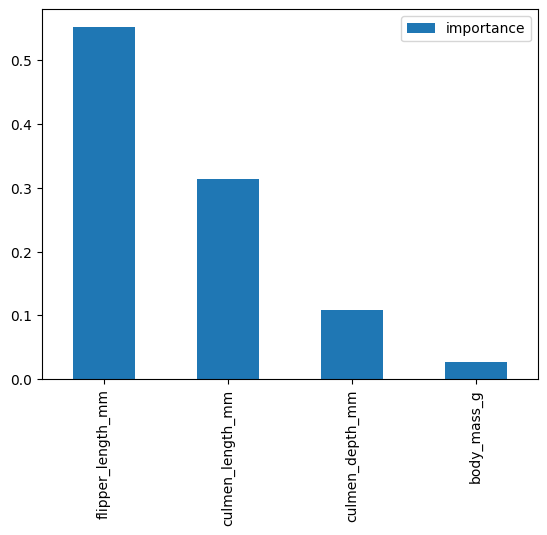

In [ ]:
feature_names = ['culmen_length_mm',	'culmen_depth_mm',	'flipper_length_mm',	'body_mass_g']

feature_importance_dict = dict(zip(feature_names, feature_importance))

importance_df = pd.DataFrame.from_dict(feature_importance_dict,
                                       orient = 'index',
                                       columns = ['importance'])

importance_df.sort_values(by = 'importance', ascending = False, inplace = True)

print(importance_df)

importance_df.plot(kind = 'bar')

## Problem 2.5: Visualize a Decistion Tree Model

In the next code cell, create a visualization of the decision tree classifier produced from the penguins dataset.

>- For clarity, you might want to include all the code to import the appropriate modules, create the model and set the feature and target names variable in this one code cell.
>- Hint: You may want to experiment with the `max_depth` parameter if your decision tree diagram is too large to read

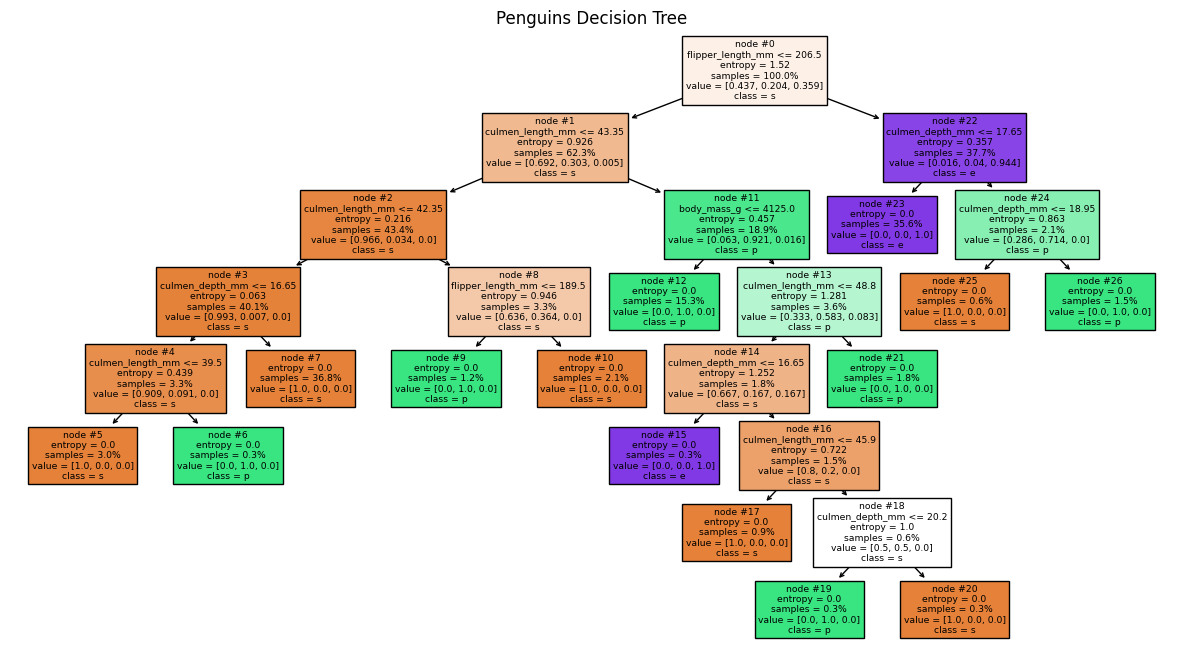

In [ ]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree

import matplotlib.pyplot as plt
import pandas as pd


plt.figure(figsize=(15,8))

plot_tree(clf,
          feature_names = ['culmen_length_mm',	'culmen_depth_mm',	'flipper_length_mm',	'body_mass_g'],
          class_names = 'species',
          filled=True,
          proportion=True,
          node_ids = True)

plt.title("Penguins Decision Tree")
plt.show()